In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from google.colab import drive
import keras
import tensorflow as tf
from scipy.ndimage import zoom

In [43]:
tf.__version__

'2.13.0'

In [15]:
keras.__version__

'2.13.1'

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_dir = "/content/drive/MyDrive/kits23-sample/dataset"
dataset_folder_path = '/content/drive/MyDrive/kits23-sample/dataset'

In [4]:
import os
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        sub_indent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(sub_indent, f))

list_files(dataset_folder_path)

    case_7/
        imaging.nii.gz
        segmentation.nii.gz
        instances/
            kidney_instance-2_annotation-1.nii.gz
            kidney_instance-1_annotation-1.nii.gz
            tumor_instance-1_annotation-3.nii.gz
            tumor_instance-1_annotation-2.nii.gz
            kidney_instance-2_annotation-3.nii.gz
            tumor_instance-1_annotation-1.nii.gz
            kidney_instance-2_annotation-2.nii.gz
            kidney_instance-1_annotation-3.nii.gz
            kidney_instance-1_annotation-2.nii.gz
    case_8/
        imaging.nii.gz
        segmentation.nii.gz
        instances/
            cyst_instance-8_annotation-2.nii.gz
            cyst_instance-1_annotation-2.nii.gz
            cyst_instance-8_annotation-1.nii.gz
            cyst_instance-2_annotation-2.nii.gz
            kidney_instance-2_annotation-1.nii.gz
            kidney_instance-1_annotation-1.nii.gz
            cyst_instance-4_annotation-2.nii.gz
            tumor_instance-1_annotation-3.nii.gz


In [5]:
#!pip install nibabel

In [5]:
def get_all_case_dirs(root_path):
    """Get all case directories under the root path."""
    paths = [os.path.join(root_path, d) for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))]
    return paths

def safe_load_nii_gz_data(case_path, filename):
    """Load .nii.gz data using nibabel, return None if file doesn't exist."""
    file_path = os.path.join(case_path, filename)
    if os.path.exists(file_path):
        nii_data = nib.load(file_path)
        return nii_data.get_fdata()
    else:
        print(f"File {file_path} not found.")
        return None

def visualize_slice(data, slice_index):
    """Visualize a slice of the 3D data."""
    plt.imshow(data[slice_index, :, :].T, cmap="gray")
    plt.axis('off')
    plt.show()



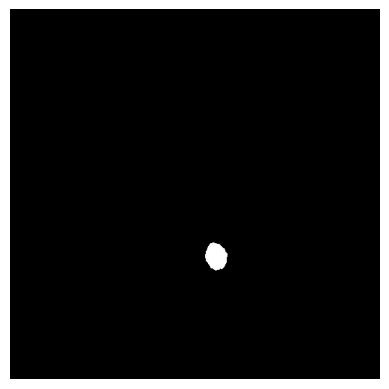

(64, 512, 512)
<class 'numpy.ndarray'>
[0. 1. 2.]


In [27]:
all_case_dirs = get_all_case_dirs(dataset_dir)

# Loading segmentations for the first few cases and visualize the first one that works
for case_dir in all_case_dirs[:10]:  # only testing first 10 for quick verification
    if case_dir.endswith('.ipynb_checkpoints') : continue
    segmentation_data = safe_load_nii_gz_data("/content/drive/MyDrive/kits23-sample/dataset/case_4", "segmentation.nii.gz")
    if segmentation_data is not None:
        visualize_slice(segmentation_data, 50)
        print(segmentation_data.shape)
        print(type(segmentation_data))
        print(np.unique(segmentation_data))
        break


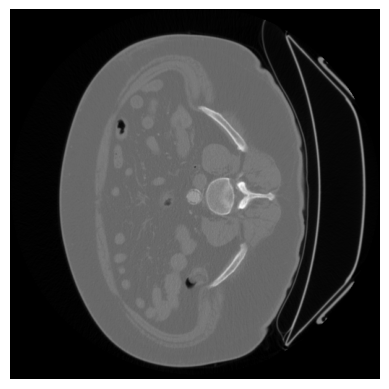

In [7]:
# Loading segmentations for the first few cases and visualize the first one that works
for case_dir in all_case_dirs[:10]:  # only testing first 10 for quick verification
    if case_dir.endswith('.ipynb_checkpoints') : continue
    segmentation_data = safe_load_nii_gz_data("/content/drive/MyDrive/kits23-sample/dataset/case_4", "imaging.nii.gz")
    if segmentation_data is not None:
        visualize_slice(segmentation_data, 60)
        break

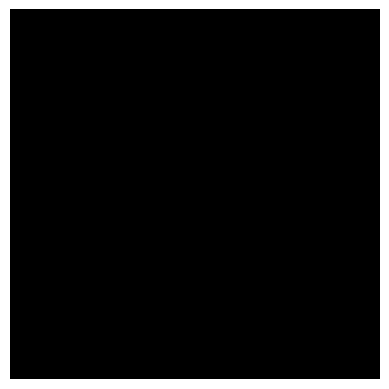

In [8]:
# Loading segmentations for the first few cases and visualize the first one that works
for case_dir in all_case_dirs[:10]:  # only testing first 10 for quick verification
    if case_dir.endswith('.ipynb_checkpoints') : continue
    segmentation_data = safe_load_nii_gz_data("/content/drive/MyDrive/kits23-sample/dataset/case_4/instances", "tumor_instance-1_annotation-1.nii.gz")
    if segmentation_data is not None:
        visualize_slice(segmentation_data, 60)
        break

In [9]:
seg_file = nib.load("/content/drive/MyDrive/kits23-sample/dataset/case_4/segmentation.nii.gz").get_fdata()
seg_file = seg_file.astype(np.uint8)

print(np.unique(seg_file))

[0 1 2]


In [43]:
#!python "/content/drive/MyDrive/kits23-sample/kits23/annotation/visualize.py" -c case_0 -d "/content/drive/MyDrive/kits23-sample/dataset/case_0/png_axial_view"

/content/drive/MyDrive/kits23-sample/kits23/annotation/visualize.py:81: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  vol = vol.get_data()
/content/drive/MyDrive/kits23-sample/kits23/annotation/visualize.py:82: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  seg = seg.get_data()


#Filtering Out Incomplete Data

### Data Preparation

####Cleaning the dataset by identifying and removing any cases that lack the segmentation.nii.gz file. If a case lacks segmentation.nii.gz, it implies that we don't have a reference segmentation for that particular case, making it unsuitable for training (since we wouldn't have a ground truth to compare the model's output to).

In [6]:
# Helper function to determine if a directory contains at least one instance (kidney, tumor, or cyst)
def contains_instance(case_dir):
    instance_files = os.listdir(case_dir)
    for filename in instance_files:
        if filename.startswith(("kidney", "tumor", "cyst")):
            return True
    return False


In [7]:
# List all cases
all_cases = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

In [8]:
# Filter cases that have segmentation.nii.gz and at least one instance
valid_cases = [
    case
    for case in all_cases
    if os.path.exists(os.path.join(dataset_dir, case, "segmentation.nii.gz")) and
    contains_instance(os.path.join(dataset_dir, case, "instances"))
]

print(f"Total cases: {len(all_cases)}")
print(f"Valid cases with segmentation and at least one instance: {len(valid_cases)}")



Total cases: 39
Valid cases with segmentation and at least one instance: 38


In [23]:
# Print the names of the valid cases in order
print("\nNames of valid cases:")
for case_name in sorted(valid_cases):
    print(case_name)



Names of valid cases:
case_0
case_1
case_11
case_12
case_13
case_14
case_15
case_16
case_17
case_18
case_19
case_2
case_21
case_22
case_23
case_24
case_25
case_26
case_27
case_28
case_29
case_3
case_4
case_5
case_579
case_58
case_581
case_582
case_583
case_584
case_585
case_586
case_587
case_588
case_6
case_7
case_8
case_9


In [13]:
set(all_cases) - set(valid_cases)

{'.ipynb_checkpoints'}

#Data Preprocessing

In [9]:
#!! Need to change to 'to_categorical' using TF

def one_hot_encode(segmentation, num_classes):
    """
    One hot encodes the segmentation mask.
    Args:
    - segmentation : numpy array, the segmentation mask
    - num_classes : int, number of classes
    Returns:
    - one_hot : numpy array, the one-hot encoded mask
    """
    one_hot = np.zeros((*segmentation.shape, num_classes))
    for i in range(num_classes):
        one_hot[..., i] = (segmentation == i)
    return one_hot


In [10]:
def preprocess_data(image, label, num_classes=4):
    """
    Preprocesses the image and label:
    - Resizes to the target shape.
    - Normalizes the image to [0, 1] range.
    - One-hot encodes the label.

    Parameters:
    - image: The MRI image.
    - label: The corresponding label.

    Returns:
    - preprocessed_image: Resized and normalized image.
    - preprocessed_label: Resized and one-hot encoded label.
    """

    # Determine the current shape of the image data
    current_shape = image.shape

    # Calculate the zoom factors
    zoom_factors = (128/current_shape[0], 128/current_shape[1], 64/current_shape[2])

    # Resizing
    resized_image = zoom(image, zoom_factors, mode='nearest')
    resized_label = zoom(label, zoom_factors, order=0, mode='nearest')
    # using order=0 (nearest neighbor) for labels

    # Normalizing image data to [0, 1]
    normalized_image = (resized_image - np.min(resized_image)) / (np.max(resized_image) - np.min(resized_image))

    # One-hot encode the label
    one_hot_label = one_hot_encode(resized_label, num_classes)
    # print(one_hot_label)

    return normalized_image, one_hot_label


#Generator : data is loaded and preprocessed on-the-fly during training

In [11]:
 #Each batch is consistent and has a shape (batch_size, 128, 128, 64, 1) for images and (batch_size, 128, 128, 64, num_classes) for labels
def data_generator(case_list, dataset_dir, batch_size=2, image_shape=(128, 128, 64, 1), num_classes=4):
    while True:
        # Randomly sample batch_size cases
        batch_cases = np.random.choice(case_list, size=batch_size)

        batch_images = []
        batch_labels = []

        for case in batch_cases:
            instances_dir = os.path.join(dataset_dir, case)

            # List all instance files within the directory
            all_files = os.listdir(instances_dir)

            # Filter out the kidney, cyst, and tumor instances
            image_files = [f for f in all_files if f.startswith("segmentation")]

            # print(image_files)

            if not image_files:
                continue  # If there are no instance files, skip this case

            # Select a random instance for this case (assuming each case might have different instances)
            random_instance = np.random.choice(image_files)

            image_path = os.path.join(instances_dir, random_instance)
            label_path = os.path.join(dataset_dir, case, 'segmentation.nii.gz')

            # Load the image and label
            image = nib.load(image_path).get_fdata()
            label = nib.load(label_path).get_fdata()

            #print(np.unique(label))

            # Preprocess (resize and normalize) the image and label
            image, label = preprocess_data(image, label)

            # One-hot encode the labels
            #label = one_hot_encode(label, num_classes=num_classes)

            batch_images.append(image)
            batch_labels.append(label)

        # Ensure batch size consistency
        while len(batch_images) < batch_size:
            # simply reuse the data from the current batch. This is a basic approach, may change it
            batch_images.extend(batch_images[:batch_size - len(batch_images)])
            batch_labels.extend(batch_labels[:batch_size - len(batch_labels)])

        # Convert lists to numpy arrays and try to reshape them to ensure the consistency
        batch_images = np.array(batch_images)
        batch_labels = np.array(batch_labels)

        # Print the shapes before reshaping
        # print("Shapes before reshaping:", batch_images.shape, batch_labels.shape)

        # Now, try reshaping , problem here
        try:
            batch_images = batch_images.reshape((batch_size, *image_shape))
            batch_labels = batch_labels.reshape((batch_size, *image_shape[:-1], num_classes))
        except ValueError as e:
            print(f"Error reshaping for batch: {e}")
            print("Cases in the problematic batch:", batch_cases)
            continue  # Skip the problematic batch

        yield (batch_images, batch_labels)

#Splitting Dataset into Training and Validation

In [12]:
from sklearn.model_selection import train_test_split
train_cases, val_cases = train_test_split(valid_cases, test_size=0.1)  # Split 10% for validation

In [14]:
print(train_cases)

['case_585', 'case_15', 'case_7', 'case_26', 'case_14', 'case_19', 'case_584', 'case_11', 'case_586', 'case_2', 'case_587', 'case_3', 'case_8', 'case_28', 'case_27', 'case_29', 'case_579', 'case_24', 'case_58', 'case_9', 'case_583', 'case_0', 'case_25', 'case_6', 'case_13', 'case_17', 'case_22', 'case_1', 'case_588', 'case_582', 'case_16', 'case_23', 'case_4', 'case_18']


In [13]:
batch_size = 2  #change this value if needed

train_gen = data_generator(train_cases, dataset_dir, batch_size=batch_size)
val_gen = data_generator(val_cases, dataset_dir, batch_size=batch_size)

In [13]:
x, y = next(train_gen)
print(x.shape, y.shape)

(2, 128, 128, 64, 1) (2, 128, 128, 64, 4)


#Model

###Define the U-Net Model

In [40]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU

In [15]:
kernel_initializer =  'he_uniform'

In [26]:
#https://github.com/bnsreenu/python_for_microscopists/blob/master/231_234_BraTa2020_Unet_segmentation/simple_3d_unet.py

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):

    #Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    #Expansive path
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible.
    model.summary()

    return model

#Test if everything is working ok.
model = simple_unet_model(128, 128, 64, 1, 4)
print(model.input_shape)
print(model.output_shape)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 64, 1)]    0         []                            
                                                                                                  
 conv3d_19 (Conv3D)          (None, 128, 128, 64, 16)     448       ['input_2[0][0]']             
                                                                                                  
 dropout_9 (Dropout)         (None, 128, 128, 64, 16)     0         ['conv3d_19[0][0]']           
                                                                                                  
 conv3d_20 (Conv3D)          (None, 128, 128, 64, 16)     6928      ['dropout_9[0][0]']           
                                                                                            

##Define Losses, Metrics and Optimisers

In [30]:
def dice_loss(y_true, y_pred, smooth=1):
    intersection = np.sum(y_true * y_pred, axis=[1, 2, 3, 4])
    union = np.sum(y_true, axis=[1, 2, 3, 4]) + np.sum(y_pred, axis=[1, 2, 3, 4])
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return 1 - np.mean(dice)

In [34]:
# https://saturncloud.io/blog/implementing-generalized-dice-loss-for-multiclass-segmentation-in-keras/

def generalized_dice_loss(y_true, y_pred):
    # Define epsilon to prevent division by zero
    epsilon = tf.keras.backend.epsilon()

    # Calculate the sum of y_true and y_pred for each class
    y_true_sum = tf.reduce_sum(y_true, axis=[0, 1, 2, 3, 4])
    y_pred_sum = tf.reduce_sum(y_pred, axis=[0, 1, 2, 3, 4])

    # Calculate the intersection and union of y_true and y_pred
    intersection = tf.reduce_sum(y_true * y_pred, axis=[0, 1, 2, 3, 4])
    union = y_true_sum + y_pred_sum

    # Calculate the Dice coefficient for each class
    dice = (2. * intersection + epsilon) / (union + epsilon)

    # Calculate the weight for each class
    weight = 1. / ((y_true_sum**2) + epsilon)

    # Calculate the generalized Dice loss
    generalized_dice = tf.reduce_sum(weight * dice)
    generalized_dice_loss = 1. - (2. * generalized_dice)

    return generalized_dice_loss

In [44]:
# https://stackoverflow.com/questions/66023106/how-to-create-hybrid-loss-consisting-from-dice-loss-and-focal-loss-python

def dice_coef(y_true, y_pred, smooth=1e-16):
    y_true_f = tf.nest.flatten(y_true)
    y_pred_f = tf.nest.flatten(y_pred)
    intersection = tf.math.reduce_sum(tf.math.multiply(y_true_f, y_pred_f))
    return (2. * intersection + smooth) / (tf.math.reduce_sum(y_true_f) + tf.math.reduce_sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels=4):
    dice=0
    for index in range(numLabels):
        dice -= dice_coef(y_true[..., index], y_pred[..., index])
    return numLabels + dice

In [48]:
# It would be ideal to use IOUScore as another metric
metrics = ['accuracy', keras.metrics.MeanIoU(4)]

In [37]:
STEPS_PER_EPOCH = len(train_cases) // batch_size
lr = 0.0001

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  lr,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=10,
  staircase=False)

optimizer_Adam = Adam(learning_rate=lr_schedule)

#Train Model

## Set Up Callbacks

In [51]:
def create_model_cp_dir(model_name):
  parent_directory = "/content/drive/MyDrive/kits23-sample/CheckPointing"
  leaf_directory = parent_directory + model_name + "/"
  full_directory = leaf_directory + model_name + ".{epoch:04d}-{val_loss:.4f}.ckpt"
  if not os.path.exists(leaf_directory):
    os.mkdir(leaf_directory)
  return full_directory

def create_saved_model_dir(model_name):
  parent_directory = "/content/drive/MyDrive/kits23-sample/SavedModels"
  leaf_directory = parent_directory + model_name + "/"
  full_directory = leaf_directory + model_name + ".h5"
  if not os.path.exists(leaf_directory):
    os.mkdir(leaf_directory)
  return full_directory

def get_callbacks(model_name):
  return [
    # tf.keras.callbacks.TensorBoard(logdir/str(model_name), histogram_freq=1),
    tf.keras.callbacks.ModelCheckpoint(create_model_cp_dir(model_name),
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 monitor = 'val_loss',
                                                 mode = 'min',
                                                 save_best_only = True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
  ]

In [42]:
# Number of steps per epoch should be the number of batches of data  per epoch
steps_per_epoch = len(train_cases) // batch_size
validation_steps = len(val_cases) // batch_size  # similar calculation for validation data

## Compile Model

In [49]:
# We should include callbacks e.g. Early Stopping
model.compile(optimizer = optimizer_Adam, loss=dice_coef_multilabel, metrics=metrics)

In [50]:
history=model.fit(train_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=10,
          verbose=2,
          validation_data=val_gen,
          validation_steps=validation_steps,
          )

Epoch 1/10
17/17 - 160s - loss: 3.5959 - accuracy: 0.0771 - mean_io_u: 0.3750 - val_loss: 3.5457 - val_accuracy: 0.3469 - val_mean_io_u: 0.3750 - 160s/epoch - 9s/step
Epoch 2/10
17/17 - 142s - loss: 3.3051 - accuracy: 0.5342 - mean_io_u: 0.4825 - val_loss: 3.0722 - val_accuracy: 0.8630 - val_mean_io_u: 0.7934 - 142s/epoch - 8s/step
Epoch 3/10
17/17 - 118s - loss: 3.0431 - accuracy: 0.9011 - mean_io_u: 0.8754 - val_loss: 3.0101 - val_accuracy: 0.9668 - val_mean_io_u: 0.9544 - 118s/epoch - 7s/step
Epoch 4/10
17/17 - 108s - loss: 3.0093 - accuracy: 0.9630 - mean_io_u: 0.9520 - val_loss: 3.0053 - val_accuracy: 0.9840 - val_mean_io_u: 0.9785 - 108s/epoch - 6s/step
Epoch 5/10
17/17 - 124s - loss: 3.0089 - accuracy: 0.9799 - mean_io_u: 0.9735 - val_loss: 3.0051 - val_accuracy: 0.9898 - val_mean_io_u: 0.9862 - 124s/epoch - 7s/step
Epoch 6/10
17/17 - 107s - loss: 3.0077 - accuracy: 0.9845 - mean_io_u: 0.9796 - val_loss: 3.0035 - val_accuracy: 0.9931 - val_mean_io_u: 0.9904 - 107s/epoch - 6s/ste

# Plot Metrics

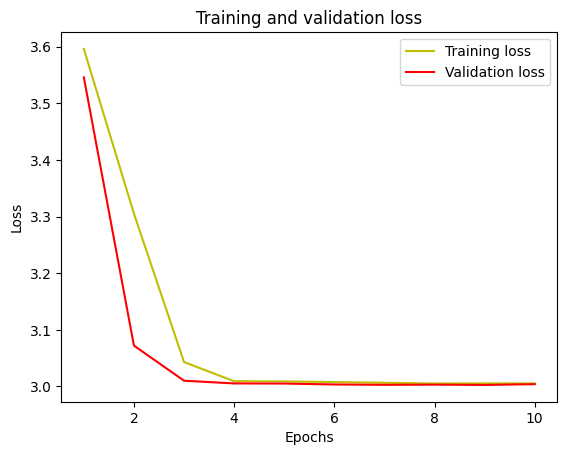

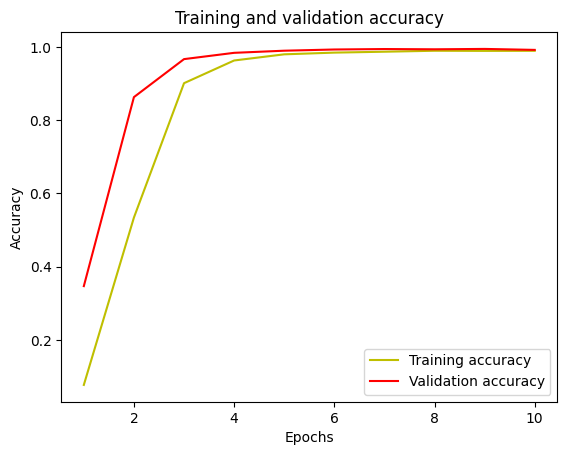

In [52]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

